   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

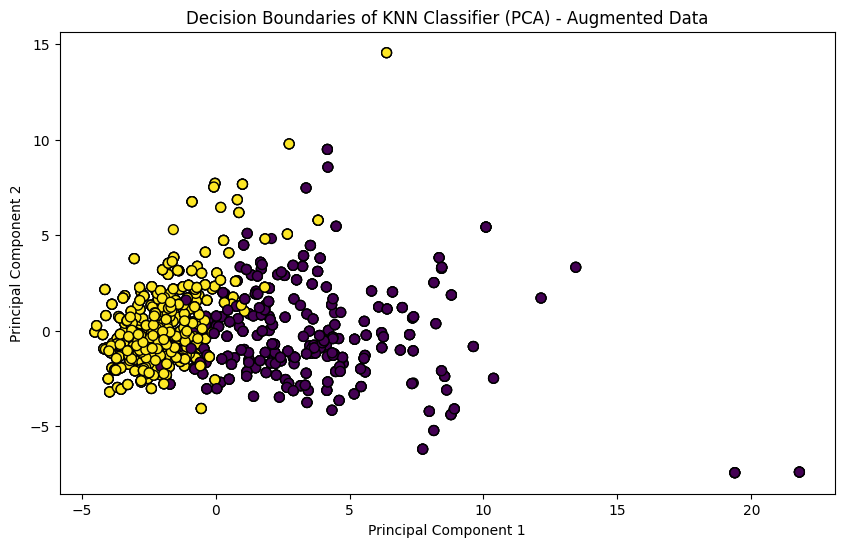

The model predicts that the tumor is benign.


C:\Users\sanat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.utils import shuffle

# Load the breast cancer dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Explore the dataset
print(df.head())

# Duplicate the dataset to increase its size
df_augmented = pd.concat([df] * 5, ignore_index=True)

# Shuffle the augmented dataset
df_augmented = shuffle(df_augmented, random_state=42)

# Preprocess the data
X_augmented = df_augmented.drop('target', axis=1)
y_augmented = df_augmented['target']

# Check the number of features
num_features_expected = 30
num_features_actual = X_augmented.shape[1]

if num_features_actual != num_features_expected:
    raise ValueError(f"Number of features is incorrect. Expected {num_features_expected}, but got {num_features_actual}.")

# Split the augmented data into training and testing sets
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(
    X_augmented, y_augmented, test_size=0.2, random_state=42
)

# Standardize the features using RobustScaler to handle outliers
scaler = RobustScaler()
X_train_scaled_augmented = scaler.fit_transform(X_train_augmented)
X_test_scaled_augmented = scaler.transform(X_test_augmented)

# Hyperparameter Tuning using GridSearchCV
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled_augmented, y_train_augmented)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_k = best_params['n_neighbors']

# Train the model with the best hyperparameters
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Perform cross-validation to check for overfitting
cv_accuracy = cross_val_score(knn_model, X_train_scaled_augmented, y_train_augmented, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_accuracy)

# Print the mean cross-validation accuracy
print(f'Mean Cross-Validation Accuracy: {mean_cv_accuracy}')

# Fit the model on the training data
knn_model.fit(X_train_scaled_augmented, y_train_augmented)

# Make predictions on the test set
y_pred_augmented = knn_model.predict(X_test_scaled_augmented)

# Evaluate the model
accuracy_augmented = accuracy_score(y_test_augmented, y_pred_augmented)
conf_matrix_augmented = confusion_matrix(y_test_augmented, y_pred_augmented)
classification_rep_augmented = classification_report(y_test_augmented, y_pred_augmented)

# Print the results
print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy on Test Set: {accuracy_augmented}')
print('Confusion Matrix:\n', conf_matrix_augmented)
print('Classification Report:\n', classification_rep_augmented)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_train_pca_augmented = pca.fit_transform(X_train_scaled_augmented)

# Visualize Decision Boundaries in 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca_augmented[:, 0], X_train_pca_augmented[:, 1], c=y_train_augmented, cmap='viridis', s=50, edgecolors='k')
plt.title('Decision Boundaries of KNN Classifier (PCA) - Augmented Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Ask the user if they want to test by adding their own data
test_option = input("Do you want to test by adding your own data? (yes/no): ").lower()

if test_option == "yes":
    # Create a prompt for user input
    user_input = []
    for feature_name in data.feature_names:
        while True:
            try:
                # Use a simple example in the prompt for guidance
                example_value = 42 if feature_name.lower() == "mean radius" else 0.15
                
                # Ask the user to enter the value for the current attribute
                value_str = input(f"Enter the value for {feature_name} (e.g., {example_value}): ")
                
                # Convert the entered value to the required data type
                value = float(value_str)  # Change this based on the actual data type

                # Append the value to the user_input list
                user_input.append(value)
                
                # Break out of the while loop if the input is successful
                break
            except ValueError:
                print(f"Invalid input. Please enter a valid numerical value for {feature_name}.")

    # Standardize the user input using the same scaler used for training
    user_input_scaled = scaler.transform([user_input])

    try:
        # Make a prediction using the trained model
        prediction = knn_model.predict(user_input_scaled)

        # Display the prediction
        if prediction[0] == 0:
            print("The model predicts that the tumor is malignant.")
        else:
            print("The model predicts that the tumor is benign.")
    except ValueError as e:
        print(f"Prediction error: {e}")
else:
    print("Program execution stopped.")
